# Sistema de Recomendação de Filmes Utilizando SVD e KNN com o MovieLens


## Preparando Dados


In [1]:
%pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 KB 4.7 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=2804025 sha256=96d9c99d4fedcad38bb36f5865466cc8bb6bb4b8feca18018f6a60db00734d7a
  Stored in directory: /home/rena/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise
Note: you may need to restart the kernel to use updated packages.


In [21]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

In [2]:
DATASET_PATH = "./datasets/raw/"

In [3]:
# Ler os arquivos do dataset MovieLens
movies = pd.read_csv(f'{DATASET_PATH}/movies.csv', encoding='utf-8')
ratings = pd.read_csv(f'{DATASET_PATH}/ratings.csv', encoding='utf-8')
# links = pd.read_csv(f'{DATASET_PATH}/links.csv', encoding='utf-8')
# links.head()

In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
# column_data_types = {
#     'letterbox': 'str',
#     'imdbId': 'int64',
#     'tmdbId': 'int64',
#     'genres' : 'str',
#     'title': 'str'
# }
# custom_movies = pd.read_csv('custom_movies.csv', dtype=column_data_types, encoding='iso-8859-1')
# custom_movies.head()

In [6]:
# new_movies = [element for element in custom_movies["imdbId"] if element not in links["imdbId"]]
# print(new_movies)

In [7]:
# non_integer_values = custom_movies[~custom_movies['tmdbId'].apply(lambda x: np.issubdtype(x, np.integer))]['tmdbId']
# print(non_integer_values)

In [8]:
# filtered_df = custom_movies[custom_movies['imdbId'].isin(new_movies)]
# filtered_df['imdbId'] = filtered_df['imdbId'].astype(int)
# filtered_df['tmdbId'] = filtered_df['tmdbId'].astype(int)
# filtered_df.head()

In [9]:
# max_movie_id = movies["movieId"].max()
# print(max_movie_id)

In [10]:
# import numpy as np
# max_movie_id = max_movie_id + 1 
# new_ids = np.arange(max_movie_id, max_movie_id + len(filtered_df))
# print(new_ids)

In [11]:
# filtered_df['movieId'] = new_ids
# filtered_df = filtered_df.drop(["letterbox", "imdb", "tmdb"], axis=1)
# filtered_df.head()

In [12]:
# combined_movies = pd.concat([filtered_df, movies], ignore_index=True)
# combined_movies.head()


In [13]:
# Agregrar as informações das avaliações aos filmes
data = pd.merge(movies, ratings, on="movieId")
data = data.drop(["timestamp"], axis=1)

data['genres'] = data['genres'].str.split('|')

data.head()

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1,4.0
1,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",5,4.0
2,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",7,4.5
3,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",15,2.5
4,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",17,4.5


## Exibindo informações


#### Analisando a quantidade de filmes e usuários disponíveis no dataset


In [14]:
print(f'Total unique movies: {len(data["movieId"].unique())}')
print(f'Total unique user: {len(data["userId"].unique())}')

ratings.head()

Total unique movies: 9724
Total unique user: 610


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


#### Analisando a quantidade de filmes por gênero


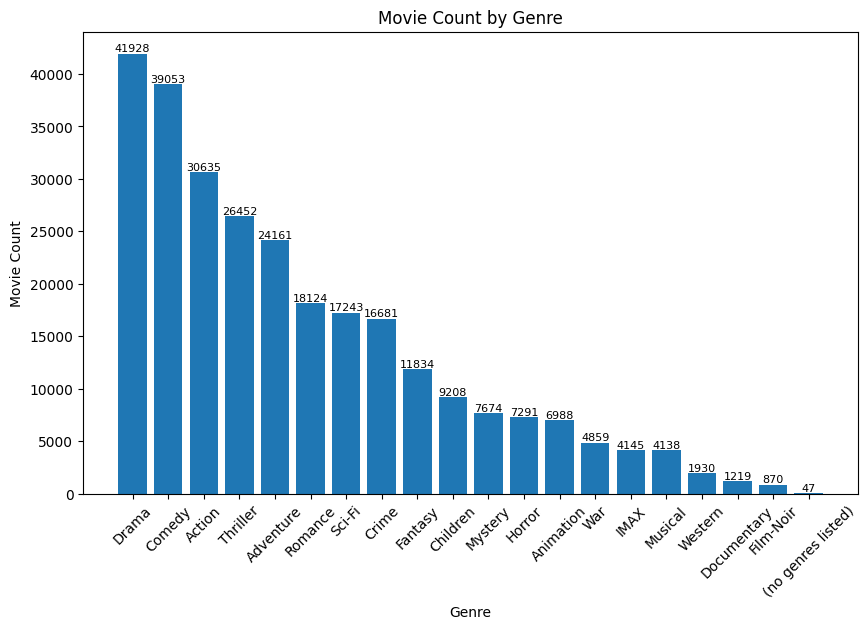

In [15]:
genre_counts = data.explode('genres')['genres'].value_counts().to_dict()

genres = list(genre_counts.keys())
counts = list(genre_counts.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(genres, counts)
plt.xlabel('Genre')
plt.ylabel('Movie Count')
plt.title('Movie Count by Genre')
plt.xticks(rotation=45)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, yval, ha='center', va='bottom', fontsize=8)

plt.show()

#### Analisando as avaliações dos usuários


In [16]:
min_rating = data["rating"].min()
max_rating = data["rating"].max()

print(f"Max movie rating: {max_rating}")
print(f"Min movie rating: {min_rating}")

Max movie rating: 5.0
Min movie rating: 0.5


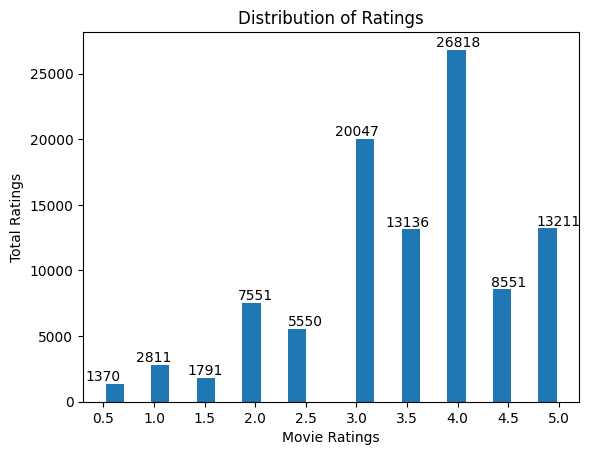

In [17]:
plt.hist(data['rating'], bins=20, rwidth=0.8)

plt.xlabel('Movie Ratings')
plt.ylabel('Total Ratings')
plt.title('Distribution of Ratings')

value_counts = data['rating'].value_counts()

unique_values = value_counts.index
ticks = [value for value in unique_values if value_counts[value] > 0]
plt.xticks(ticks)

for value in unique_values:
    count = value_counts[value]
    if count > 0:
        plt.text(value, count, str(count), ha='center', va='bottom')

plt.show()


#### Analisando os dados de um usuário

Escolhemos utilizar o usuário com id 1 para ser a base de comparação dos resultados do sistema.


In [42]:
user_1 = data.loc[data['userId'] == 1]
user_1 = user_1.sort_values("rating", ascending=False)
user_1.head(20)  

,movieId,title,genres,userId,rating
65533,5060,M*A*S*H (a.k.a. MASH) (1970),"[Comedy, Drama, War]",1,5.0
48949,2872,Excalibur (1981),"[Adventure, Fantasy]",1,5.0
29325,1291,Indiana Jones and the Last Crusade (1989),"[Action, Adventure]",1,5.0
29560,1298,Pink Floyd: The Wall (1982),"[Drama, Musical]",1,5.0
49664,2948,From Russia with Love (1963),"[Action, Adventure, Thriller]",1,5.0
49611,2947,Goldfinger (1964),"[Action, Adventure, Thriller]",1,5.0
49572,2944,"Dirty Dozen, The (1967)","[Action, Drama, War]",1,5.0
49110,2899,Gulliver's Travels (1939),"[Adventure, Animation, Children]",1,5.0
48643,2858,American Beauty (1999),"[Drama, Romance]",1,5.0
46713,2700,"South Park: Bigger, Longer and Uncut (1999)","[Animation, Comedy, Musical]",1,5.0


In [19]:
movie_1 = data.loc[data['movieId'] == 750]
movie_1.head(1)

,movieId,title,genres,userId,rating
18537,750,Dr. Strangelove or: How I Learned to Stop Worr...,"[Comedy, War]",7,4.0


In [20]:
dataset = pa.Table.from_pandas(data)
pq.write_table(dataset, "./datasets/refined/dataset.parquet")

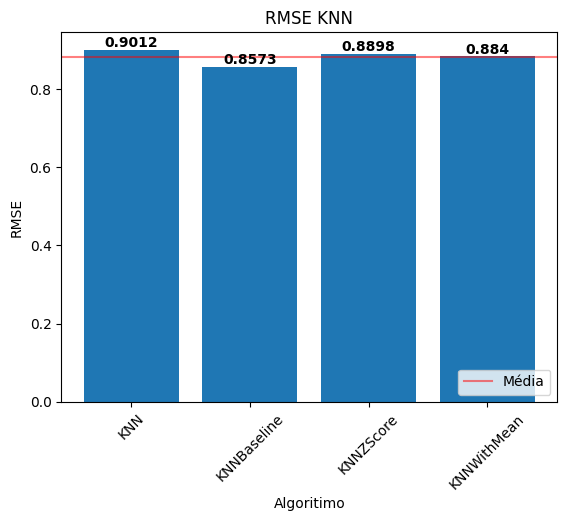

In [39]:
metodo = ["KNN", "KNNBaseline", "KNNZScore", "KNNWithMean"]
values = [0.9012, 0.8573,  0.8898, 0.8840]

avg_value = sum(values) / len(values)

bars = plt.bar(metodo, values)
plt.xlabel('Algoritimo')
plt.ylabel('RMSE')
plt.title('RMSE KNN')
plt.xticks(rotation=45)


plt.axhline(y=avg_value, color='r', linestyle='-', label='Média', alpha=0.5)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, yval, ha='center', va='bottom', fontsize=10, fontweight='bold')


# Show the legend
plt.legend(loc='lower right')

plt.show()


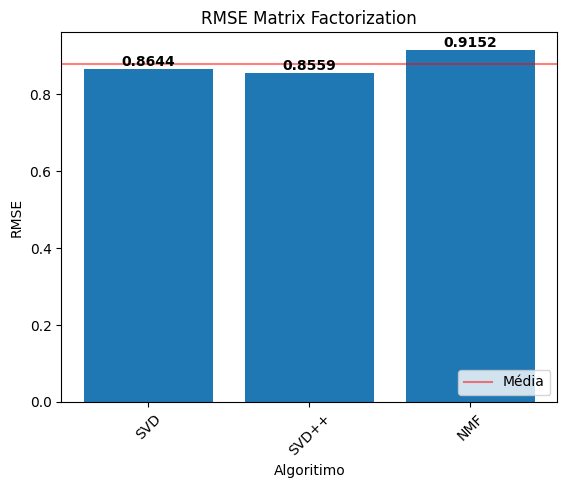

In [40]:
metodo = ["SVD", "SVD++", "NMF"]
values = [0.8644, 0.8559, 0.9152]

avg_value = sum(values) / len(values)

bars = plt.bar(metodo, values)
plt.xlabel('Algoritimo')
plt.ylabel('RMSE')
plt.title('RMSE Matrix Factorization')
plt.xticks(rotation=45)


plt.axhline(y=avg_value, color='r', linestyle='-', label='Média', alpha=0.5)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, yval, ha='center', va='bottom', fontsize=10, fontweight='bold')


# Show the legend
plt.legend(loc='lower right')

plt.show()


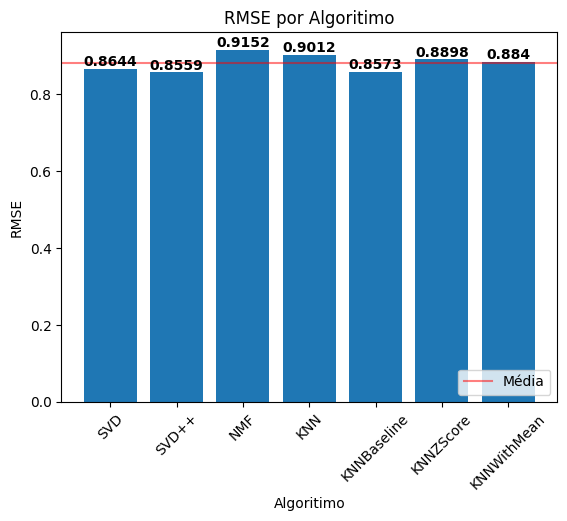

In [36]:
metodo = ["SVD", "SVD++", "NMF", "KNN", "KNNBaseline", "KNNZScore", "KNNWithMean"]
values = [0.8644, 0.8559, 0.9152, 0.9012, 0.8573,  0.8898, 0.8840]

avg_value = sum(values) / len(values)

bars = plt.bar(metodo, values)
plt.xlabel('Algoritimo')
plt.ylabel('RMSE')
plt.title('RMSE por Algoritimo')
plt.xticks(rotation=45)


plt.axhline(y=avg_value, color='r', linestyle='-', label='Média', alpha=0.5)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, yval, ha='center', va='bottom', fontsize=10, fontweight='bold')


# Show the legend
plt.legend(loc='lower right')

plt.show()


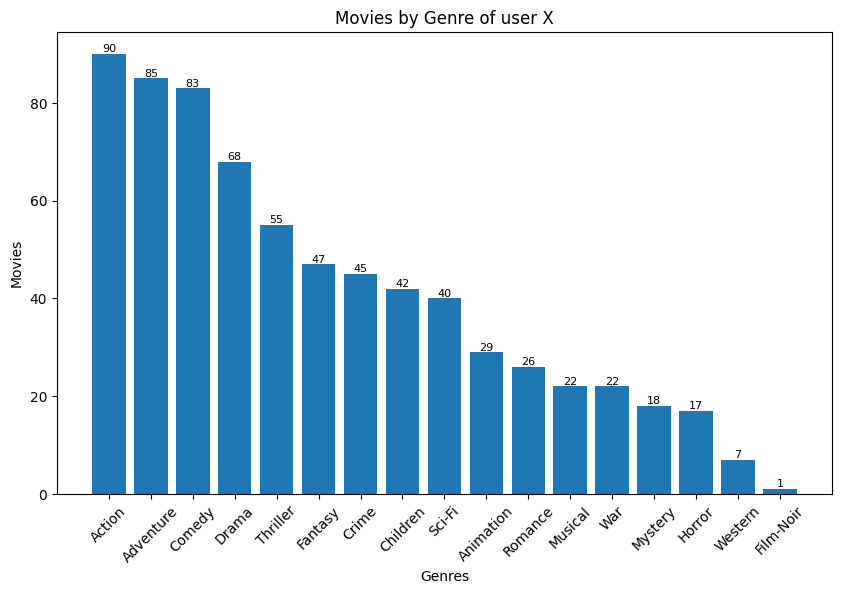

In [46]:
genre_counts = user_1.explode('genres')['genres'].value_counts().to_dict()

genres = list(genre_counts.keys())
counts = list(genre_counts.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(genres, counts)
plt.xlabel('Genres')
plt.ylabel('Movies')
plt.title('Movies by Genre of user X')
plt.xticks(rotation=45)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, yval, ha='center', va='bottom', fontsize=8)

plt.show()